In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import itertools
from plotnine import *
from IPython.core import display as ICD
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix, classification_report, log_loss

/Users/mattspinnelli/anaconda3/envs/ser627a/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [17]:
n_splits = 8
animals = pd.read_csv('animals.csv')
animals.drop("ImputatedSex", inplace=True, axis=1)
animals = animals.rename(columns = {'Unnamed: 0':'ID'})
# [(i, x) for i, x in enumerate(animals.columns)]

In [18]:
animals.Hair = pd.Categorical(animals.Hair).codes # NaN becomes -1
animals.loc[animals.Hair == -1, 'Hair'] = np.nan
cols = [0] + range(11,39)
cats = animals[animals.AnimalType=='Cat'].iloc[:,cols]
dogs = animals[animals.AnimalType=='Dog'].iloc[:,cols]

Fix the NaN values for cats and dogs seperately because we have some different columns for each and don't want to impute values using the median from the other animal type.

In [19]:
# pd.isnull(cats).sum() > 0

In [20]:
imputer = Imputer(strategy='median')   

# for cats set values taht make sense for these (i.e. 1-5 scale: choose 3)
cats.iloc[:, 10:26] = 5
cats['Avg Weight (pounds)'] = 9
cats['Avg Height (inches)'] = 9
cats['Avg Age'] = 12
dogs.Hair = 2

In [21]:
dogs = pd.merge(dogs, pd.DataFrame(imputer.fit_transform(dogs), columns = animals.iloc[:, cols].columns), 
                how='inner', on='ID').iloc[:, [0] + range(29, 57)] 

cats = pd.merge(cats, pd.DataFrame(imputer.fit_transform(cats), columns = animals.iloc[:, cols].columns), 
                how='inner', on='ID').iloc[:, [0] + range(29, 57)]

outcomes = pd.DataFrame(animals.iloc[:, [0, 4]])
animals = pd.concat([dogs, cats])
animals = pd.merge(animals, outcomes, on='ID')
animals.columns = [x.replace('_y', '') for x in animals.columns]

# pd.isnull(animals).sum() > 0

In [22]:
def run_skf(data, n_splits):
    skf = StratifiedKFold(n_splits, random_state=8, shuffle=True)
    t = data.OutcomeType
    train, test = [], []
    for train_index, validate_index in skf.split(np.zeros(len(t)), t):
        train.append(data.iloc[train_index])
        test.append(data.iloc[validate_index])
    return train, test

In [23]:
def visualize_folds(data, train, test):
    print('Number of training samples: {}\n'.format(len(data)))
    print('Training sample size per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .ID.rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(train)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

    print('Test samples per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .ID.rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(test)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

In [24]:
data, validate = train_test_split(animals, test_size=1./(n_splits+1), random_state=8)
print 'Number of samples before splitting: {}'.format(len(animals))
print 'Number of validation samples: {}'.format(len(validate))
train, test = run_skf(data, n_splits=n_splits)
visualize_folds(data, train, test)

Number of samples before splitting: 26729
Number of validation samples: 2970
Number of training samples: 23759

Training sample size per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,8356,152,1204,3745,7330,20787
Fold 2,8356,152,1205,3745,7330,20788
Fold 3,8356,152,1205,3745,7331,20789
Fold 4,8356,152,1205,3745,7331,20789
Fold 5,8356,152,1205,3745,7331,20789
Fold 6,8356,152,1205,3745,7331,20789
Fold 7,8357,153,1205,3745,7331,20791
Fold 8,8357,153,1205,3745,7331,20791


Test samples per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,1194,22,173,535,1048,2972
Fold 2,1194,22,172,535,1048,2971
Fold 3,1194,22,172,535,1047,2970
Fold 4,1194,22,172,535,1047,2970
Fold 5,1194,22,172,535,1047,2970
Fold 6,1194,22,172,535,1047,2970
Fold 7,1193,21,172,535,1047,2968
Fold 8,1193,21,172,535,1047,2968


In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)

In [26]:
def plot_results(clf, log_loss_train, log_loss_test, test, train, pred_test, target_names, i):
    print('Train log loss:', log_loss_train)
    print('Test log loss:', log_loss_test)
    
    cm = confusion_matrix(test[i].OutcomeType.tolist(), pred_test, labels=target_names)
    plot_confusion_matrix(
        cm, target_names,
        title='Confusion Matrix for Fold {0} of {1}'.format(i+1, len(train)))
    print(classification_report(test[i].OutcomeType.tolist(), 
                            pred_test, target_names=target_names))
    
    # Print the feature ranking
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    X = train[i].iloc[:,1:-1]
#     print("Feature ranking:")
#     for f in range(X.shape[1]):
#         print("%d. feature %s (%f)" % (f, X.columns[indices[f]], importances[indices[f]]))
        
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [30]:
def run_forest_run(n_estimators, max_depth, avg_log_loss_train, avg_log_loss_test, 
                   test, train, target_names, i, n_jobs=1):    
    clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth, 
                                 random_state=8, n_jobs = n_jobs, max_features=None)  

    clf.fit(train[i].iloc[:,1:-1], train[i].OutcomeType)
    pred_train = clf.predict(train[i].iloc[:,1:-1])
    pred_test = clf.predict(test[i].iloc[:,1:-1])
    
    pred_train = pd.Categorical(pred_train, categories=target_names)
    pred_test = pd.Categorical(pred_test, categories=target_names)
    
    k1_train = pd.get_dummies(pred_train)
    k1_test = pd.get_dummies(pred_test)
    k1_train = k1_train.reindex_axis(sorted(k1_train.columns), axis=1)
    k1_test = k1_test.reindex_axis(sorted(k1_test.columns), axis=1)
    
    log_loss_train = log_loss(pd.get_dummies(train[i].OutcomeType), k1_train)
    log_loss_test = log_loss(pd.get_dummies(test[i].OutcomeType), k1_test)
       
    avg_log_loss_train += log_loss_train
    avg_log_loss_test += log_loss_test
    
    return clf, pred_train, pred_test, log_loss_train, log_loss_test, avg_log_loss_test, avg_log_loss_train

('Train log loss:', 8.7115410900330392)
('Test log loss:', 10.470874001283493)
                 precision    recall  f1-score   support

       Adoption       0.71      0.84      0.77      1194
           Died       1.00      0.09      0.17        22
     Euthanasia       0.77      0.24      0.36       173
Return_to_owner       0.52      0.48      0.50       535
       Transfer       0.77      0.74      0.75      1048

    avg / total       0.70      0.70      0.68      2972



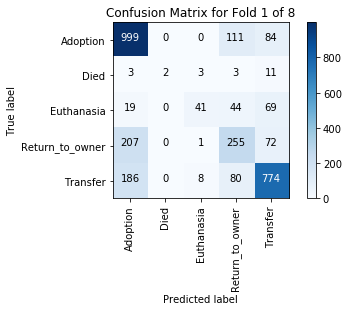

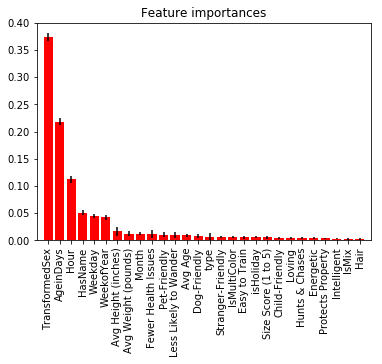

('Train log loss:', 8.8224409590617583)
('Test log loss:', 10.81153215996868)
                 precision    recall  f1-score   support

       Adoption       0.69      0.84      0.76      1194
           Died       1.00      0.14      0.24        22
     Euthanasia       0.71      0.26      0.38       172
Return_to_owner       0.50      0.47      0.48       535
       Transfer       0.77      0.70      0.74      1048

    avg / total       0.69      0.69      0.68      2971



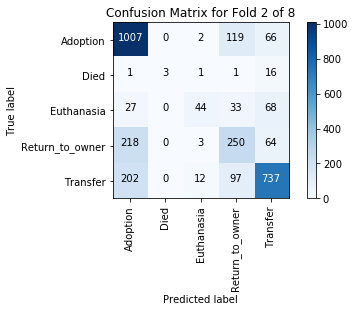

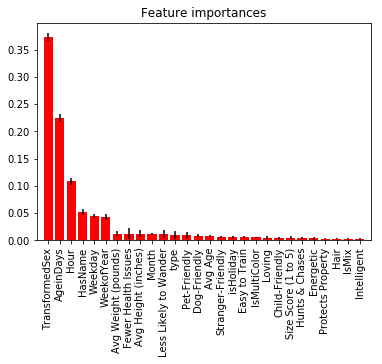

('Train log loss:', 8.7688518838009859)
('Test log loss:', 10.384891353755977)
                 precision    recall  f1-score   support

       Adoption       0.71      0.83      0.77      1194
           Died       1.00      0.27      0.43        22
     Euthanasia       0.65      0.23      0.34       172
Return_to_owner       0.54      0.54      0.54       535
       Transfer       0.77      0.72      0.74      1047

    avg / total       0.70      0.70      0.69      2970



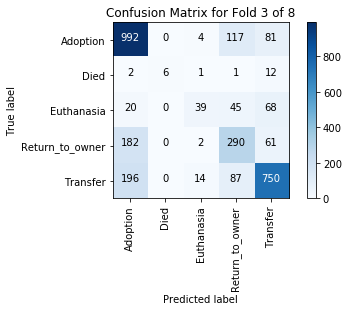

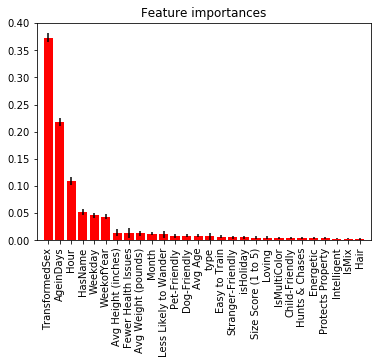

('Train log loss:', 8.8353077525679495)
('Test log loss:', 10.629104924225043)
                 precision    recall  f1-score   support

       Adoption       0.70      0.85      0.77      1194
           Died       1.00      0.14      0.24        22
     Euthanasia       0.57      0.19      0.28       172
Return_to_owner       0.53      0.47      0.50       535
       Transfer       0.77      0.72      0.74      1047

    avg / total       0.69      0.69      0.68      2970



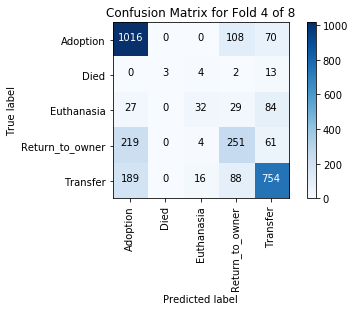

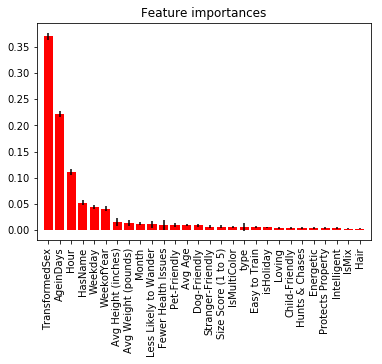

('Train log loss:', 8.6724908740888864)
('Test log loss:', 11.338487200349469)
                 precision    recall  f1-score   support

       Adoption       0.69      0.83      0.75      1194
           Died       0.33      0.05      0.08        22
     Euthanasia       0.60      0.16      0.25       172
Return_to_owner       0.47      0.46      0.46       535
       Transfer       0.76      0.70      0.73      1047

    avg / total       0.67      0.67      0.66      2970



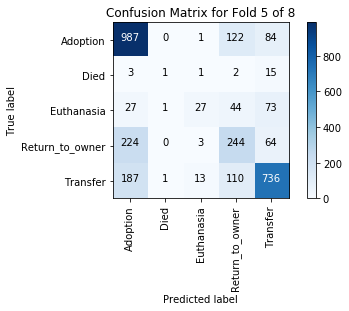

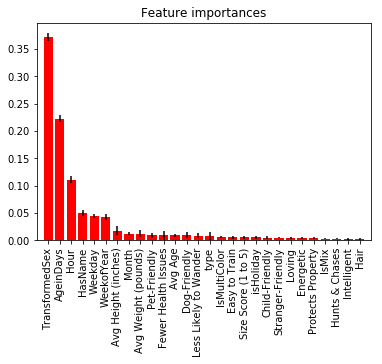

('Train log loss:', 8.6675066839313626)
('Test log loss:', 10.512812747811202)
                 precision    recall  f1-score   support

       Adoption       0.69      0.86      0.77      1194
           Died       0.67      0.09      0.16        22
     Euthanasia       0.64      0.21      0.32       172
Return_to_owner       0.53      0.47      0.50       535
       Transfer       0.78      0.72      0.75      1047

    avg / total       0.69      0.70      0.68      2970



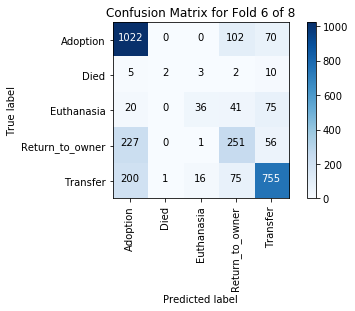

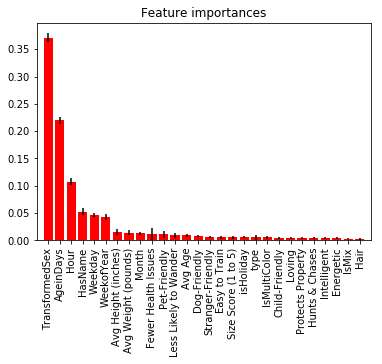

('Train log loss:', 8.8062168086874895)
('Test log loss:', 10.857371420637358)
                 precision    recall  f1-score   support

       Adoption       0.69      0.85      0.76      1193
           Died       0.33      0.05      0.08        21
     Euthanasia       0.70      0.15      0.25       172
Return_to_owner       0.51      0.49      0.50       535
       Transfer       0.76      0.70      0.73      1047

    avg / total       0.68      0.69      0.67      2968



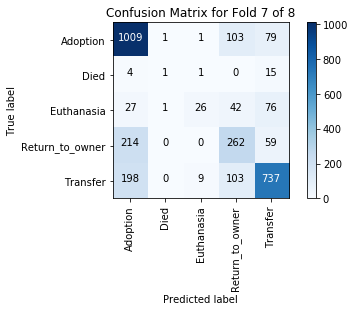

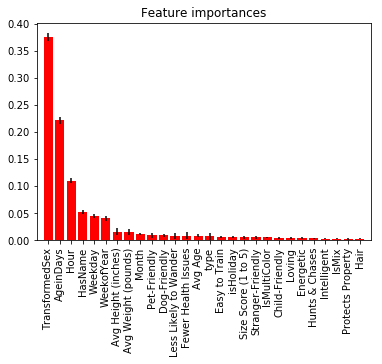

('Train log loss:', 8.6915914625642241)
('Test log loss:', 10.950467852968654)
                 precision    recall  f1-score   support

       Adoption       0.70      0.83      0.76      1193
           Died       0.40      0.10      0.15        21
     Euthanasia       0.62      0.20      0.30       172
Return_to_owner       0.51      0.49      0.50       535
       Transfer       0.75      0.71      0.73      1047

    avg / total       0.68      0.68      0.67      2968



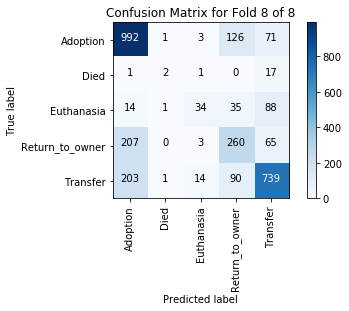

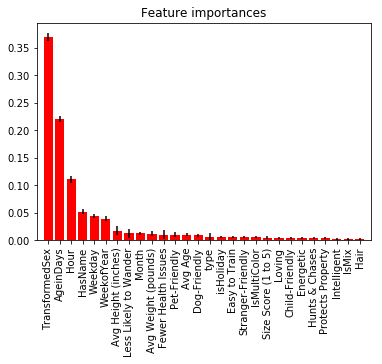

('Avg. train log loss:', 8.7469934393419617)
('Avg. test log loss:', 10.744442707624986)


In [38]:
target_names = sort(animals.OutcomeType.unique())
avg_log_loss_train = 0
avg_log_loss_test = 0

for i in range(n_splits):
    (clf, pred_train, pred_test, 
     log_loss_train, log_loss_test,
     avg_log_loss_test,
     avg_log_loss_train) = run_forest_run(80, 10, avg_log_loss_train, avg_log_loss_test, 
                                          test, train, target_names, i, -1)    
    plot_results(clf, log_loss_train, log_loss_test, test, train, pred_test, target_names, i)

avg_log_loss_train /= n_splits
avg_log_loss_test /= n_splits
print('Avg. train log loss:', avg_log_loss_train)
print('Avg. test log loss:', avg_log_loss_test)
    

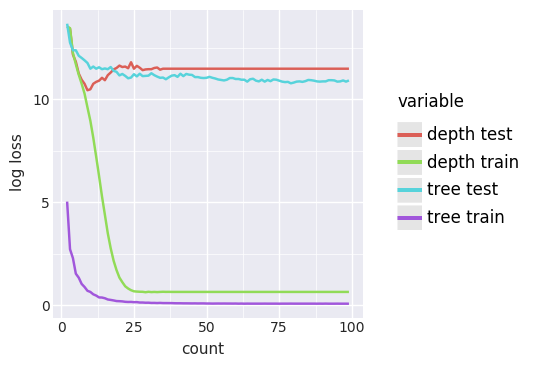

In [29]:
from multiprocessing import Pool

def iteration(i):
    try:
        (_, pred_train, pred_test, 
         log_loss_train_depth, log_loss_test_depth,
         _, _) = run_forest_run(10, i, 0, 0, test, train, target_names, 0)

        (_, pred_train, pred_test, 
         log_loss_train_tree, log_loss_test_tree,
         _, _) = run_forest_run(i, None, 0, 0, test, train, target_names, 0) 
        return (i, log_loss_train_tree, log_loss_test_tree, log_loss_train_depth, log_loss_test_depth)
    except:
        import traceback
        traceback.print_exc()

range_ = range(2, 100)
p = Pool(processes=8)
result = p.map(iteration, range_)

p.close()
p.join()

columns = ['count', 'tree train', 'tree test', 'depth train', 'depth test']
ln_loss = pd.DataFrame(result, columns=columns)
ln_loss = pd.melt(ln_loss, id_vars=['count'], value_vars=columns[1:])

(ggplot(ln_loss, aes(x='count', y='value', color='variable'))
 + geom_line(size=1)
 + theme_seaborn()
 + theme(panel_grid_minor = element_line(size=0.5))
 + ylab('log loss')
).draw().set_size_inches(4, 4)

In [39]:
# remove cat/dog specific fields:
animals = animals.iloc[:, range(0, 10) + [26, 28, 29]] 

('Train log loss:', 7.3390953642334429)
('Test log loss:', 10.680059053473396)
                 precision    recall  f1-score   support

       Adoption       0.71      0.81      0.76      1194
           Died       0.60      0.14      0.22        22
     Euthanasia       0.64      0.27      0.38       173
Return_to_owner       0.51      0.50      0.51       535
       Transfer       0.76      0.73      0.75      1048

    avg / total       0.69      0.69      0.68      2972



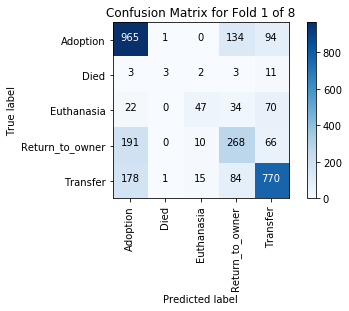

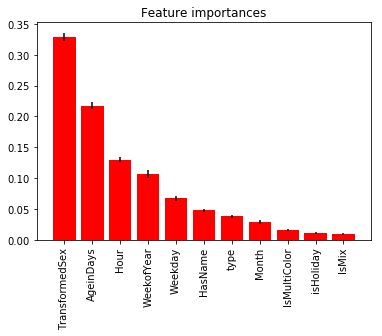

('Train log loss:', 7.3852636653539578)
('Test log loss:', 10.788281553173048)
                 precision    recall  f1-score   support

       Adoption       0.71      0.82      0.76      1194
           Died       1.00      0.09      0.17        22
     Euthanasia       0.64      0.28      0.39       172
Return_to_owner       0.49      0.48      0.49       535
       Transfer       0.77      0.72      0.74      1048

    avg / total       0.69      0.69      0.68      2971



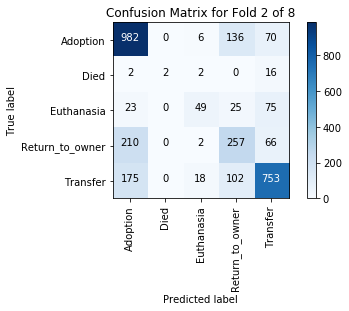

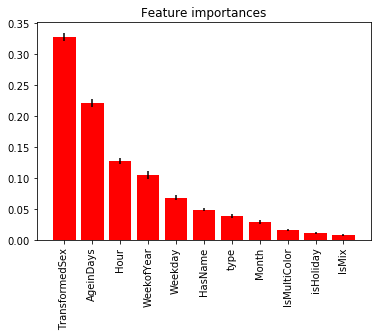

('Train log loss:', 7.4015223839206872)
('Test log loss:', 10.350003700831826)
                 precision    recall  f1-score   support

       Adoption       0.72      0.82      0.77      1194
           Died       0.67      0.27      0.39        22
     Euthanasia       0.60      0.22      0.32       172
Return_to_owner       0.52      0.52      0.52       535
       Transfer       0.77      0.74      0.76      1047

    avg / total       0.70      0.70      0.69      2970



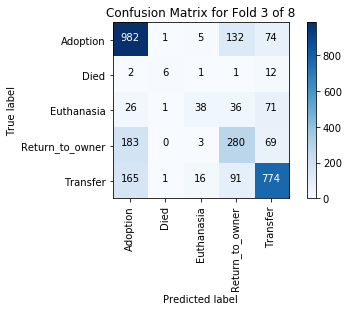

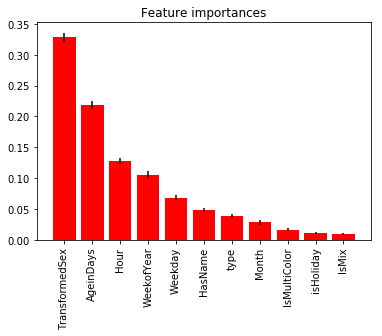

('Train log loss:', 7.4081679707973835)
('Test log loss:', 10.67562179479058)
                 precision    recall  f1-score   support

       Adoption       0.71      0.84      0.77      1194
           Died       0.80      0.18      0.30        22
     Euthanasia       0.53      0.19      0.28       172
Return_to_owner       0.50      0.44      0.47       535
       Transfer       0.76      0.74      0.75      1047

    avg / total       0.68      0.69      0.68      2970



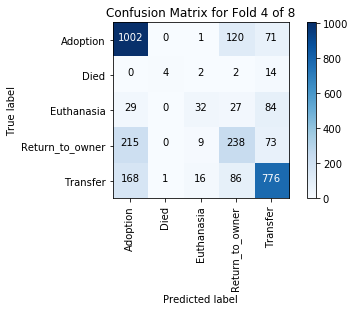

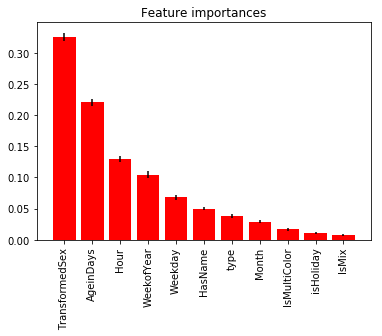

('Train log loss:', 7.3034999774894143)
('Test log loss:', 11.454779376763312)
                 precision    recall  f1-score   support

       Adoption       0.68      0.81      0.74      1194
           Died       0.38      0.14      0.20        22
     Euthanasia       0.56      0.23      0.33       172
Return_to_owner       0.46      0.43      0.44       535
       Transfer       0.76      0.71      0.74      1047

    avg / total       0.66      0.67      0.66      2970



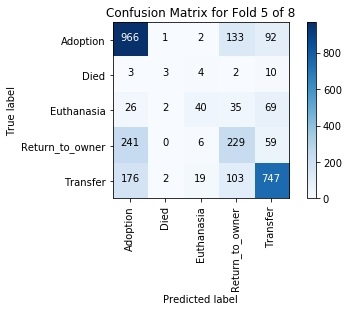

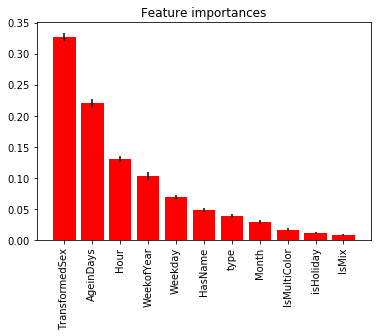

('Train log loss:', 7.3134683578044593)
('Test log loss:', 10.722138665356116)
                 precision    recall  f1-score   support

       Adoption       0.70      0.83      0.76      1194
           Died       0.67      0.09      0.16        22
     Euthanasia       0.60      0.24      0.35       172
Return_to_owner       0.52      0.48      0.50       535
       Transfer       0.76      0.72      0.74      1047

    avg / total       0.68      0.69      0.68      2970



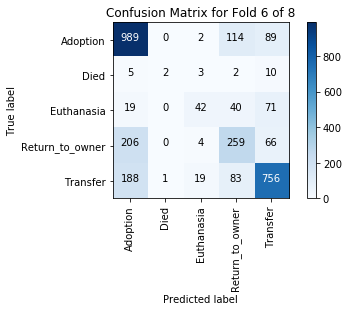

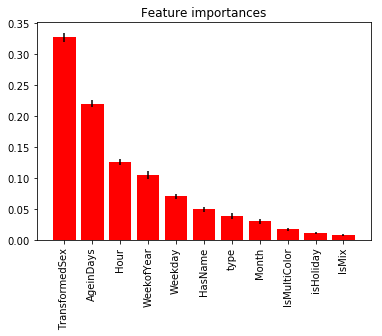

('Train log loss:', 7.434035129008965)
('Test log loss:', 10.962104907010067)
                 precision    recall  f1-score   support

       Adoption       0.70      0.82      0.75      1193
           Died       0.33      0.05      0.08        21
     Euthanasia       0.64      0.19      0.29       172
Return_to_owner       0.50      0.50      0.50       535
       Transfer       0.76      0.72      0.74      1047

    avg / total       0.68      0.68      0.67      2968



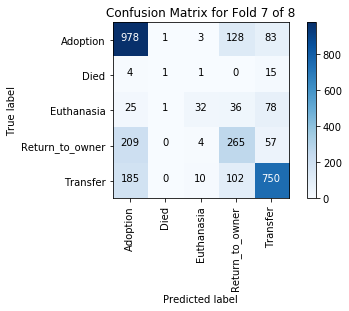

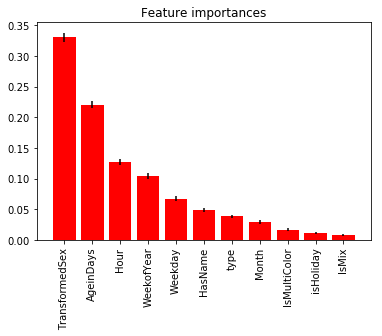

('Train log loss:', 7.422406470706604)
('Test log loss:', 11.078475447424186)
                 precision    recall  f1-score   support

       Adoption       0.70      0.81      0.75      1193
           Died       0.33      0.10      0.15        21
     Euthanasia       0.56      0.21      0.31       172
Return_to_owner       0.49      0.49      0.49       535
       Transfer       0.76      0.71      0.74      1047

    avg / total       0.67      0.68      0.67      2968



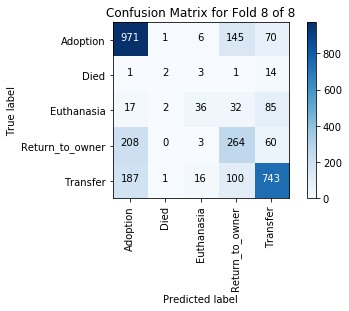

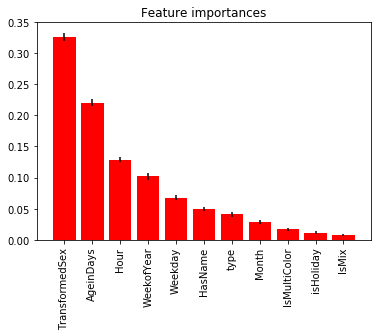

('Avg. train log loss:', 7.3759324149143648)
('Avg. test log loss:', 10.838933062352817)


In [40]:
data, validate = train_test_split(animals, test_size=1./(n_splits+1), random_state=8)
train, test = run_skf(data, n_splits=n_splits)

avg_log_loss_train = 0
avg_log_loss_test = 0

for i in range(n_splits):
    (clf, pred_train, pred_test, 
     log_loss_train, log_loss_test,
     avg_log_loss_test,
     avg_log_loss_train) = run_forest_run(80, 12, avg_log_loss_train, avg_log_loss_test, 
                                          test, train, target_names, i)    
    plot_results(clf, log_loss_train, log_loss_test, test, train, pred_test, target_names, i)

avg_log_loss_train /= n_splits
avg_log_loss_test /= n_splits
print('Avg. train log loss:', avg_log_loss_train)
print('Avg. test log loss:', avg_log_loss_test)

# TODO

* Try changing TransformedSex to not umpute Unknowns (and just just change the one NaN to an unknown). I think this will improve the results.